# Retail sales analysis and forecasting

This notebook is an analysis of a retail brand transactions record. the idea was to answer basic questions (How many product were offered on week 50 ? What is the best selling product overall ?) and then try to forecast sales for the upcoming week in the dataset (week 98), using two methods (ARIMA and Random Forest) and comparing them. For further infrmation, do not hesitate to contact me at [louis.auneau.g@gmail.com](mailto:louis.auneau@amadeus.com) (I am also looking for a data science engineering position !).

## Abstract  

This study is about time series analysis and forecasting, applied to a retail company's transactions dataset. After data load, clean and preparation, a quick descriptive analysis shows that transactions are given for one and a half years. The business sales rose for the first 4 months and then stabilize for the rest of the time frame. It also shows a weekly seasonality and a probable yearly cycle with an important sales day followed by a day without any sales. Our analysis also allows us to state that **$11 861$ products were offered by the company at week 50**, and that the **best selling product overall is regular gasoline**, generating a total **$\$477754.49$** in revenue for the company.  
  
  
After this analysis, two models are tuned and evaluated : ARIMA (AutoRegressive Integrated Moving Average) and Random Forests.  
  
ARIMA model requires further statistical analysis (stationarity check, ACF and PACF graphical analysis...) to determine a reasonable hyper-parameters search space. This analysis indicated that we are facing a seasonal data set, and thus need to train a Seasonal ARIMA (SARMIA). A grid search, using cross-validation and BIC/AIC/RMSE evaluation led us to the model $𝑆𝐴𝑅𝐼𝑀𝐴((2,0,1)(0,1,1)[7])$. The fitted model well captures the weekly seasonality, average sales and stable mean sales, but fails to capture the yearly seasonality sales peak and overall fluctuations. The **SARIMA model forecasts a $\$87317.36$ total sales value for week 98**.
  
For the random forest, further feature engineering is done, to derive time related features. The model hyper-parameters are also determined but this time using a random grid search because of a large search space. The random grid search uses forward chaining cross-validation with RMSE as a scoring function. This models shares the same characteristics as the SARIMA model (accurate average sales and weekly seasonality, no yearly seasonality detection and poor nosie detection). **The forecast for week 98 sales with the fitted random forest model is $\$91280.44$**.

When measuring errors between the two models, none of them pops out, as they have fairly similar errors rates. Thereby, we may choose a model over the other mostly for implementation-based reasons. SARIMA, which is simpler to implement, requires less feature engineering, and makes the model behaviour easier to understand, would be preferable in these conditions. One key improvement for that project would be to gather at least two cycle of the yearly seasonality to capture it as it holds important business value.

## Content

[1. Introduction](#1.-Introduction)  
[2. Methods](#2.-Methods)  
...... [2.1 Data collection](#2.1-Data-collection)  
...... [2.2 Data cleaning and pre-processing](#2.2-Data-cleaning-and-pre-processing)  
............ [2.2.1 Null values](#2.2.1-Null-values)  
............ [2.2.2 Datetime generation](#2.2.2-Datetime-generation)  
............ [2.2.3 Sales value time serie creation](#2.2.3-Sales-value-time-serie-creation)  
...... [2.3 Descriptive Analysis](#2.3-Descriptive-Analysis)  
............ [2.3.1 General tendencies](#2.3.1-General-tendencies)  
............ [2.3.2 Products offered](#2.3.2-Products-offered)  
............ [2.3.3 Best selling product overall](#2.3.3-Best-selling-product-overall)  
...... [2.4 Predictive Models](#2.4-Predictive-Models)  
............ [2.4.1 ARIMA](#2.4.1-ARIMA)  
.................. [2.4.1.1 Stationarity analysis and differencing hyper-parameter (d) estimation](#2.4.1.1-Stationarity-analysis-and-differencing-hyper-parameter-(d)-estimation)  
.................. [2.4.1.2 Auto-regression hyper-parameter (p)](#2.4.1.2-Auto-regression-hyper-parameter-(p))  
.................. [2.4.1.3 Moving Average hyper-parameter (q)](#2.4.1.3-Moving-Average-hyper-parameter-(q))  
.................. [2.4.1.4 Model hyper-parameters tuning](#2.4.1.4-Model-hyper-parameters-tuning)  
............ [2.4.2 Random Forests](#2.4.2-Random-Forests)  
.................. [2.4.2.1 Feature engineering](#2.4.2.1-Feature-engineering)  
.................. [2.4.2.2 Hyper-parameters tuning using Randomized Search](#2.4.2.2-Hyper-parameters-tuning-using-Randomized-Search)  
.................. [2.4.2.3 Forecasting using Random Forest](#2.4.2.3-Forecasting-using-Random-Forest)  
[3. Results](#3.-Results)  
[4. Resources](#4.-Resources)  

## 1. Introduction

Time series analysis and forecasting is becoming an increasingly important field for businesses, as forecasting allows them to reduce uncertainty, and plan operation way ahead. Applications can range from figuring out personal customer behaviour to getting global trends over millions of customers. Walmart was among the first retailers to realize the importance of data storage and analysis, to better organize its supply chain, its price offer, and much more.  
In this document, we will mainly focus on sales forecasting basic approaches. We use the transaction log of a retailer to gain insights about the data, and precise information about the business such as the product count or the best selling products (section 2.3). Then in section 2.4, we develop two sales forecasting models, and compare them.

## 2. Methods

### 2.1 Data collection

Before processing the data, we import all needed packages needed for the analysis.

In [239]:
# Data structures
import pandas as pd
import numpy as np

# Visualization and notebook management
import pylab as pl
import matplotlib.pyplot as plt
from IPython.display import display

# ML helpers
import statsmodels.api as sm
import statsmodels.graphics as smg
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Python packages
import math
from datetime import datetime, timedelta
import itertools
import warnings

Let's start by loading all CSVs and display first rows to get a better grasp of the data.

In [2]:
demographic = pd.read_csv("data/demographic.csv")
products = pd.read_csv("data/product.csv")
transactions = pd.read_csv("data/transaction_data.csv")

In [3]:
display(demographic.head())
display(products.head())
display(transactions.head())

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


### 2.2 Data cleaning and pre-processing

#### 2.2.1 Null values

First, we need to check empty values for `DAY`, `WEEK_NO`, `TRANS_TIME`, `SALES_VALUE` and `QUANTITY` columns of the `transactions` dataset, as it will be the columns we are going to manipulate for this project.

In [4]:
transactions.isnull().sum()

household_key        0
BASKET_ID            0
DAY                  0
PRODUCT_ID           0
QUANTITY             0
SALES_VALUE          0
STORE_ID             0
RETAIL_DISC          0
TRANS_TIME           0
WEEK_NO              0
COUPON_DISC          0
COUPON_MATCH_DISC    0
dtype: int64

There are no null values, so we don't need to replace any value.  
  
#### 2.2.2 Datetime generation
Then, as our ARIMA model will be a time serie forecasting model, transforming the transactions' week, day and time into a proper datetime object is necessary. We lack precise dates, so we will choose a baseline date (*1/1/1900*) and assume transactions started on that day. Regarding transactions' time, it was represented as an integer, with thousands and hundreds used to encode hours, and tens and units used to encode minutes. We are going to parse it and include it in the datetime. This function may take a few minutes to be executed as the task is repeated for all transactions.

In [5]:
def parse_datetime(transaction):
    """
    Takes a transaction row from the `transaction_data.csv` file, and uses `TRANS_TIME` and `DAY` columns to create a datetime object.
    """
    time = transaction["TRANS_TIME"]
    
    if len(time) == 1:
        time = '000'+ time
    elif len(time) == 2: #len being O(1) in python it's ok tu use it twice
        time = '00' + time
        
    return datetime.strptime(time, '%H%M') + timedelta(days=transaction["DAY"] - 1) # (-1 as the `DAY` column is 1 indexed)

In [6]:
transactions["TRANS_TIME"] = transactions["TRANS_TIME"].astype(str) # We need to cast transaction times to avoid automatic coercion by python.
transactions["DATETIME"] = transactions.apply(parse_datetime, axis=1)
display(transactions.head())

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,DATETIME
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0,1900-01-01 16:31:00
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0,1900-01-01 16:31:00
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0,1900-01-01 16:31:00
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0,1900-01-01 16:31:00
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0,1900-01-01 16:31:00


#### 2.2.3 Sales value time serie creation

The datetime we generated allows us to create a time serie (as a [Pandas Serie](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html)). We will generate a time series at a day scale, which allows us to keep a really good precision for our ARIMA model ($\approx100$ per Box and Tiao [1]), while reducing greatly the size of the data handled by our future models.

In [7]:
daily_sales_ts = transactions.set_index('DATETIME').groupby(pd.Grouper(freq='D'))['SALES_VALUE'].sum()
display(daily_sales_ts.head())

print("Reduction factor: " + str(transactions.shape[0]/daily_sales_ts.count()))
print("Number of observations: " + str(daily_sales_ts.count()))

DATETIME
1900-01-01     549.31
1900-01-02     458.91
1900-01-03    1560.37
1900-01-04    1785.64
1900-01-05     856.93
Freq: D, Name: SALES_VALUE, dtype: float64

Reduction factor: 3625.384047267356
Number of observations: 677


We can see that we divided our time serie size by **3625** using a day scale.

### 2.3 Descriptive Analysis

#### 2.3.1 General tendencies

Let's start by plotting our sales time serie.

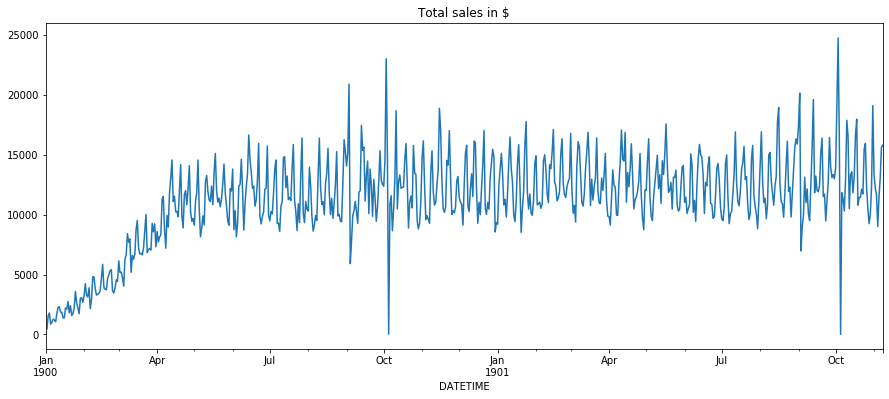

In [8]:
daily_sales_ts.plot(title="Total sales in $", figsize=(15, 6))

We already see some trends : 
- Sales aren't stationnary over the first four months. This can have an influence on our models (particularly the ARIMA Model). This might be due to a business size growth, not correlated to intrinsict sales growth.
- On the other hand, sales are quite stationary afterwards.
- There are ups and downs on a day/week scale cycle, indicating a seasonality. This has to be further checked with autocorrelation plots.
- Sales reach peaks on the 10th month, and a year after, which may indicate a yearly seasonality.

We can also get basic descriptive statistics about transactions and weekly sales values in order to better grasp our dataset characteristics. Products and demographic datasets having mainly qualitative columns, there are not really interesting.

In [9]:
transactions.describe()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
count,2.454385e+06,2.454385e+06,2.454385e+06,2.454385e+06,2.454385e+06,2.454385e+06,2.454385e+06,2.454385e+06,2.454385e+06,2.454385e+06,2.454385e+06
mean,1.271389e+03,3.356323e+10,3.711756e+02,2.843705e+06,1.004824e+02,3.099640e+00,3.070255e+03,-5.405539e-01,5.370973e+01,-1.637147e-02,-2.902686e-03
std,7.264514e+02,4.420506e+09,1.799599e+02,3.759551e+06,1.153284e+03,4.200936e+00,8.821958e+03,1.250090e+00,2.570724e+01,2.169416e-01,3.973536e-02
min,1.000000e+00,2.698485e+10,1.000000e+00,2.567100e+04,0.000000e+00,0.000000e+00,1.000000e+00,-1.800000e+02,1.000000e+00,-5.593000e+01,-7.700000e+00
25%,6.550000e+02,3.014209e+10,2.200000e+02,9.170310e+05,1.000000e+00,1.280000e+00,3.300000e+02,-6.900000e-01,3.200000e+01,0.000000e+00,0.000000e+00
50%,1.271000e+03,3.255587e+10,3.740000e+02,1.027808e+06,1.000000e+00,2.000000e+00,3.700000e+02,-3.000000e-02,5.400000e+01,0.000000e+00,0.000000e+00
75%,1.914000e+03,3.563836e+10,5.270000e+02,1.132770e+06,1.000000e+00,3.490000e+00,4.220000e+02,0.000000e+00,7.600000e+01,0.000000e+00,0.000000e+00
max,2.500000e+03,4.184806e+10,6.770000e+02,1.812030e+07,8.963800e+04,8.400000e+02,3.428000e+04,3.990000e+00,9.700000e+01,0.000000e+00,0.000000e+00


In [10]:
daily_sales_ts.describe()

count      677.000000
mean     11237.386352
std       3708.901581
min          2.990000
25%       9848.050000
50%      11498.840000
75%      13435.840000
max      24760.100000
Name: SALES_VALUE, dtype: float64

Among interesting values, we have :
- Total transactions : **2454385**
- Total days in time serie : **677**
- Mean sale value per transaction : \$**3.099640**  
- Standard Deviation on sale value per transaction : \$**4.200936**  
- Mean daily revenue : \$**11237.386352**  
- Standard weekly revenue deviation : \$**3708.901581** (Indicates lot of variability in daily sales)  

And finally the sales per week distribution :

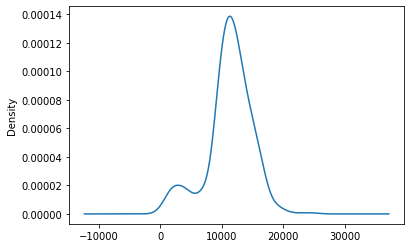

In [11]:
daily_sales_ts.plot(kind='kde')

#### 2.3.2 Products offered

How many products are offered by the store on week 50 ? In order to answer this question we have to : 
- Filter all transactions done on week 50,
- List all product IDs for those transactions,
- Count how many unique product IDs we have.

In [12]:
transactions.loc[transactions['WEEK_NO'] == 50]['PRODUCT_ID'].nunique()

11861

This gives us a total of **11861** products bought on week 50. 

#### 2.3.3 Best selling product overall

Let's consider, both best selling products in terms of units sold, and in terms of revenue generated.  
  
First, in order to find the best selling product, we need to group transactions by product IDs (`PRODUCT_ID`). And then, in order to get:
- the best selling in terms of units, sum `QUANTITY` for each product and get the top one,
- the one generating the most revenue, sum `SALES_VALUE` for each product and get the top one.

In [13]:
transactions_per_products = transactions.groupby('PRODUCT_ID');

# Per units sold
best_unit_selling_products = transactions_per_products['QUANTITY'].sum().sort_values(ascending=False)
best_unit_selling_product_id = best_unit_selling_products.index[0]
overall_amount_sold = best_unit_selling_products.values[0]
print('Best selling product is product in terms of units is ' + str(best_unit_selling_product_id) + ', sold ' + str(overall_amount_sold) + ' times overall.')

# Per revenue generated
best_selling_products = transactions_per_products['SALES_VALUE'].sum().sort_values(ascending=False)
best_selling_product_id = best_selling_products.index[0]
overall_revenue_generated = best_selling_products.values[0]
print('Best selling product is product in terms of revenue generated is ' + str(best_unit_selling_product_id) + ', generating $' + str(overall_revenue_generated) + ' overall.')

Best selling product is product in terms of units is 6534178, sold 204770364 times overall.
Best selling product is product in terms of revenue generated is 6534178, generating $477754.4900000089 overall.


Product **6534178** is both the most sold per units and the one generating the most revenue. We can get further information about the product by looking into the products dataframe :

In [14]:
products.loc[products['PRODUCT_ID'] == best_unit_selling_product_id]

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
57221,6534178,69,KIOSK-GAS,Private,COUPON/MISC ITEMS,GASOLINE-REG UNLEADED,


The best selling product is product number **6534178**, which is *Regular Gasoline*. It was sold **204770364** times overall and generated **\$477754.49** in total. The total quantity sold seems really large with regards for the total number of transactions. Let's have a deeper look by computing the median quantity sold by transactions:

In [15]:
transactions.loc[transactions["PRODUCT_ID"] == best_unit_selling_product_id]["QUANTITY"].median()

10535.5

With a median *10535 units* sold per gas transaction, we can think that gasoline is probably sold by thousandths of gallon, which explains the large quantity sold.

### 2.4 Predictive Models

Before defining our models, we remove the first four months in order to eliminate the business growth period. We then split our time serie into train and test sets in order to be able to compare the models with same test sets :

In [46]:
# Deleting skewed first 4 months
daily_sales_ts_trunc = daily_sales_ts[4*30:]

# Splitting train and test set (80%/20%)
split = int(0.80*len(daily_sales_ts_trunc))
train, test = daily_sales_ts_trunc[:split], daily_sales_ts_trunc[split:]

#### 2.4.1 ARIMA

ARIMA (Autoregressive integrated moving average) is a linear time serie modeling tool, that can be used as a supervised algorithm to forecast these time series. It has three hyper-parameters :
- `d`: This hyper-parameter is the order of differencing. The differenciation is used when the time serie is not stationary (statistical properties of the time series remain approximately constant over time). When it is not, observations are replaced by the difference between them and a lagged observation. This difference can be repeated a number of times until the serie is stationary. This is the order of differencing.
- `p`: Auto-regression term. Auto-regression expresses the dependent relationship between an data point and some number of lagged data points. The parameter is thus the number of lag observation terms included in the linear equation.
- `q`: Moving average is the dependency between a data point and a residual error from a moving average model applied to lagged data points. The parameter is thus size of the moving average window to include in the equation.

We are going to determine each of them in the following parts, using the Box-Jenkins methodology [2].

##### 2.4.1.1 Stationarity analysis and differencing hyper-parameter (d) estimation 

In order to estimate the differencing hyper-parameter, we need to know if the time serie is stationary or not. To do so, we are going to use three tools :
- Rolling statistics analysis,
- Time serie components decomposition (trend, seasonality),
- Augmented Dickey-Fuller test.

Here are three functions implementing them:

In [23]:
def plot_rolling_statistics(timeserie):
    """
    Ploting rolling mean and std over the original time serie to see if the are dependent of the time.
    """
    rolling_mean = timeserie.rolling(5).mean()
    rolling_std = timeserie.rolling(5).std()
    timeserie = plt.plot(timeserie, color='black', label='timeserie')
    mean = plt.plot(rolling_mean, label='rolling mean', color='red')
    std = plt.plot(rolling_std, label='rolling std', color='purple')
    plt.legend(loc='best')

def plot_timeserie_decomposition(timeserie):
    """
    Ploting timeserie decomposition in order to see trends and seasonality.
    """
    decomposition = sm.tsa.seasonal_decompose(timeserie)
    return decomposition
    
def augmented_dickeyfuller_test(timeserie):
    """
    Runs an augmented Dickey-Fuller test in order to determine if the timeserie is stationary.
    """
    adfullertest = sm.tsa.stattools.adfuller(timeserie)
    return "Augmented Dickey-Fuller test results\nTest statistic: " + str(adfullertest[0]) + "\np-value: " + str(adfullertest[1]) + "\nLevels: " + str(adfullertest[4])

We can run a full analysis on our original time serie, and the time serie differenced once :

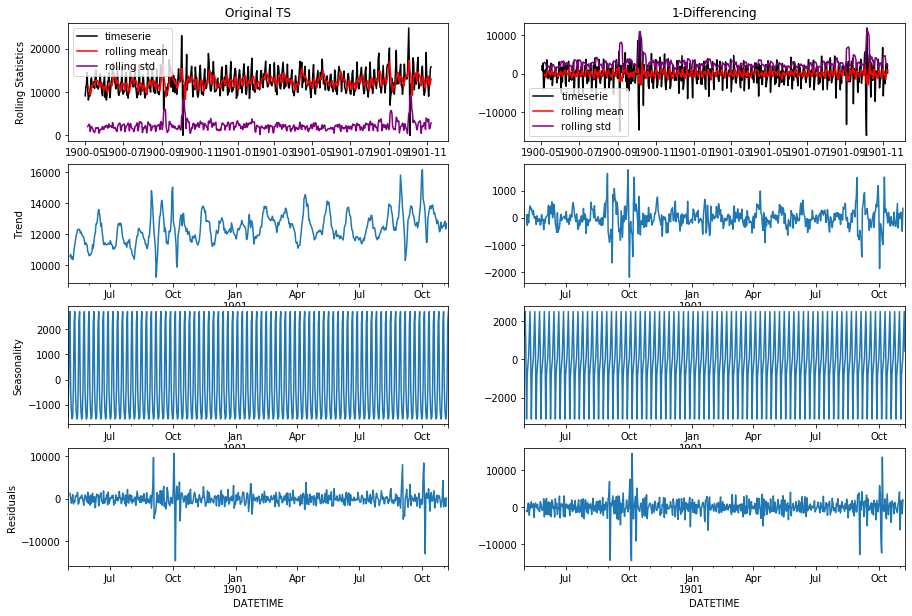

In [24]:
# Preparing subplot
figs, axes = plt.subplots(4, 2, figsize=(15,10))
axes[0][0].set_title("Original TS")
axes[0][1].set_title("1-Differencing")
axes[0][0].set_ylabel("Rolling Statistics")
axes[1][0].set_ylabel("Trend")
axes[2][0].set_ylabel("Seasonality")
axes[3][0].set_ylabel("Residuals")

# Rolling statistics
plt.sca(axes[0, 0])
plot_rolling_statistics(daily_sales_ts_trunc)
plt.sca(axes[0, 1])
plot_rolling_statistics(daily_sales_ts_trunc.diff().dropna())

# Seasonality
decomposition_ots = plot_timeserie_decomposition(daily_sales_ts_trunc)
decomposition_ots.trend.plot(ax=axes[1, 0], legend=False)
decomposition_ots.seasonal.plot(ax=axes[2, 0], legend=False)
decomposition_ots.resid.plot(ax=axes[3, 0], legend=False)
decomposition_1dfts = plot_timeserie_decomposition(daily_sales_ts_trunc.diff().dropna())
decomposition_1dfts.trend.plot(ax=axes[1, 1], legend=False)
decomposition_1dfts.seasonal.plot(ax=axes[2, 1], legend=False)
decomposition_1dfts.resid.plot(ax=axes[3, 1], legend=False)

In [25]:
# Dickey-Fuller tests
print("Original TS : ")
print(augmented_dickeyfuller_test(daily_sales_ts_trunc))
print("\n1-Differencing : ")
print(augmented_dickeyfuller_test(daily_sales_ts_trunc.diff().fillna(0)))

Original TS : 
Augmented Dickey-Fuller test results
Test statistic: -5.287129047532115
p-value: 5.822004192978842e-06
Levels: {'1%': -3.442450336733213, '5%': -2.8668774460774498, '10%': -2.5696126760816553}

1-Differencing : 
Augmented Dickey-Fuller test results
Test statistic: -10.215812553384577
p-value: 5.485622693758745e-18
Levels: {'1%': -3.4425861905056556, '5%': -2.8669372502674824, '10%': -2.5696445454608505}


From this graphical analysis, there are some key takeaways:
- Mean and standard deviation are not dependent on the time in both cases, which suggests stationarity.
- There is at least on seasonality, which is weekly. As a consequence, we will have to use a Seasonal ARIMA model (SARIMA).  
- There might be a second seasonality, yearly this time, that we can guess thanks to two spikes (appearing in october in our graphs). However, we only have one cycle between the two spikes, so we can't determine if it is a cyclic phenomenon or a seasonal phenomenon. Our model may fail to represent it. 

Complementary Augmented Dicker-Fuller tests confirm that our time serie is stationary without differentiation, as the H0 hypothesis is rejected ($p-value < 0.05$ and the test statistic is lower than $-3.44$, the critical values for Dickey–Fuller t-distribution for our serie size). **Thus $d = 0$**.

##### 2.4.1.2 Auto-regression hyper-parameter (p)

In order to estimate the `p` hyper-parameter, we are going to have a look to the Partial Autocorrelation Function (PACF). It measures the correlation between the time serie with a lagged version of itself but also eliminates variations already explained by the intervening comparisons. 

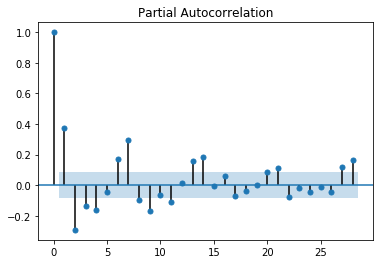

In [26]:
pacf = smg.tsaplots.plot_pacf(daily_sales_ts_trunc) # We store the figure to avoid double display in jupyter

**There are a few significant spikes (for lags of 1, 2, 3, 4, 6, 7), so we can only reduce our search space, by saying that $p \in \{1,2,3,4,6,7\}$.**

##### 2.4.1.3 Moving Average hyper-parameter (q)

In order to estimate the parameter `q`, we will have a look at the autocorrelation which shows autocorrelation between observations of the time serie at a given lag.

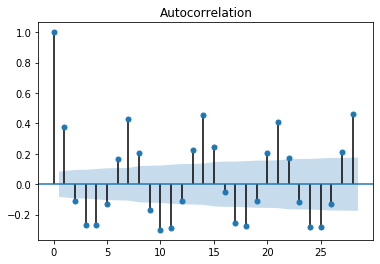

In [27]:
acf = smg.tsaplots.plot_acf(daily_sales_ts_trunc)

Again, there is not enough evidence that an autocorrelation is significantly larger than the others. We will do a grid search to confirm which value fits the best for `q`. However, a there's a significant autocorrelation for a lag of 1,3,4 and 7. So we also reduce our search space to **$q \in \{1,3,4,7\}$**.
Moreover, spikes appears every 7 lags, which confirms a seasonality of 7 (**$s = 7$**).

##### 2.4.1.4 Model hyper-parameters tuning

In order to complete our hyper-parameters tuning, we are going to do a grid search among the search space we previously defined (we also add $(P, D, Q, s)$ seasonal hyper-parameters [3]) :
- $p \in \{1,2,3,4,6,7\}$
- $d = 0$
- $q \in \{1,3,4,7\}$
- $P \in \left[0,2\right]$
- $D \in \left[0,2\right]$
- $Q \in \left[0,2\right]$
- $s = 7$

This gives us 648 models to fit and evaluate. The evaluation function of one hyper-parameters set will be the mean of a mean squared error computed over 5 different foward chained validation sets (see [4] and [time serie split in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit)) and the prediction made with a model fitted with these hyper-parameters. This allows us to be almost unbiased, while keeping the temporal dependency inside our sets. 

In [33]:
##################################################################################
#                                ARIMA GRID SEARCH                               #
##################################################################################

def sarima_forecast(train, order, seasonal_order):
    """
    Trains a SARIMA model with the given order and seasonal order, on a train set, fits its parameters.
    """
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore") # Ignoring warning message that are numerous for aberant models
        model = sm.tsa.statespace.SARIMAX(train, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        return model_fit
    
# Generating hyper-parameters sets
p = [1, 2, 3, 4, 6, 7]
d = [0]
q = [1, 3, 4, 7]
P = [0, 1, 2]
D = [0, 1, 2]
Q = [0, 1, 2]
s = [7]
orders = itertools.product(p, d, q)
seasonal_orders = itertools.product(P, D, Q, s)
hyperparameters_grid = itertools.product(orders, seasonal_orders)

# Hyperparameters evaluation metrics
models_aic = pd.Series()
models_bic = pd.Series()
models_rmse = pd.Series()

# Grid Search
for hyperparameters in hyperparameters_grid:
    print(str(hyperparameters))
    try:
        # Forward chained cross validation dataset generation
        tscv = TimeSeriesSplit(n_splits=5)   
        
        # Evaluation metrics
        hyperparameters_aic = []
        hyperparameters_bic = []
        hyperparameters_rmse = []

        # Each chained cros validation evaluation
        for train_idx, validation_idx in tscv.split(train):
            model = sarima_forecast(train[train_idx], order=hyperparameters[0], seasonal_order=hyperparameters[1])
            # Prediction only for validation dates
            predictions = model.predict(train[validation_idx].index[0], train[validation_idx].index[-1])
            
            # Evaluation on the CV set
            hyperparameters_aic.append(model.aic)
            hyperparameters_bic.append(model.bic)
            hyperparameters_rmse.append(math.sqrt(mean_squared_error(train[validation_idx], predictions)))

        # Mean RMSE/AIC/BIC for the 5 validation subsets
        models_aic[str(hyperparameters)] = np.mean(hyperparameters_aic)
        models_bic[str(hyperparameters)] = np.mean(hyperparameters_bic)
        models_rmse[str(hyperparameters)] = np.mean(hyperparameters_rmse)
    except:
        continue
    
# Results
print("Best hyper-parameters set for AIC : " + str(models_aic.idxmin()) + " - " + str(models_aic.min()))
print("Best hyper-parameters set for BIC : " + str(models_bic.idxmin()) + " - " + str(models_bic.min()))
print("Best hyper-parameters set for RMSE : " + str(models_rmse.idxmin()) + " - " + str(models_rmse.min()))

Best hyper-parameters set for AIC : ((1, 0, 1), (0, 2, 2, 7)) - 3863.0973514410116
Best hyper-parameters set for BIC : ((1, 0, 1), (0, 2, 2, 7)) - 3878.979017015011
Best hyper-parameters set for RMSE : ((2, 0, 1), (0, 1, 1, 7)) - 1794.6943480713587


Grid search gives us a minimum cross-validation root mean squared of $1794.69$ for the model parameters **$SARIMA((2, 0, 1)(0, 1, 1)[7])$**, and a minmum AIC of $3863.10$ and a minimum of BIC ($3878.98$) for the model parameters **$SARIMA((1, 0, 1)(0, 2, 2)[7])$**. We can evaluate the RMSE of these two models to see if they are significantly higher than for the first one.

In [53]:
print("RMSE SARIMA((1, 0, 1)(0, 2, 2)[7]) : " + str(models_rmse["((1, 0, 1), (0, 2, 2, 7))"]))

RMSE SARIMA((1, 0, 1)(0, 2, 2)[7]) : 2602.843800337849


With regards to $SARIMA((2, 0, 1)(0, 1, 1)[7]$ model, $SARIMA((1, 0, 1)(0, 2, 2)[7]$ has significantly higher RMSE. We will keep model $SARIMA((2, 0, 1)(0, 1, 1)[7]$ even if it may overfit the validation set. Let's plot the prediction for the test set for a graphical analysis : 

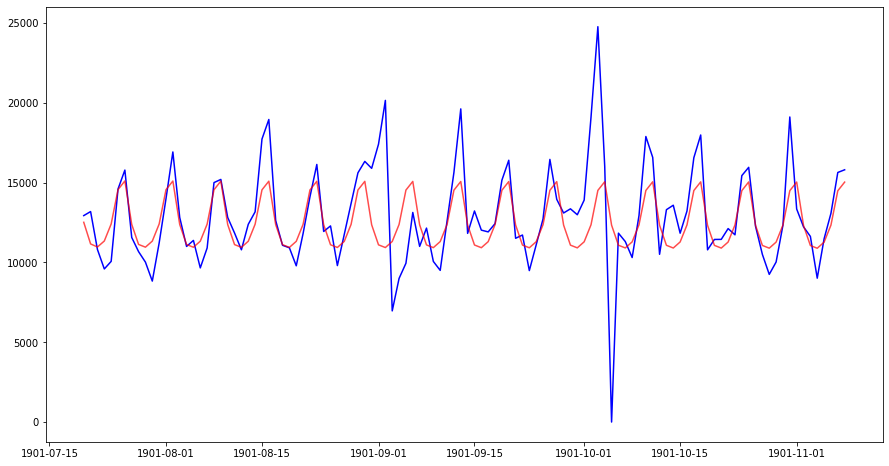

In [232]:
sarima_model = sarima_forecast(train, (2, 0, 1), (0, 1, 1, 7))
sarima_predictions = sarima_model.predict(len(train), len(train) + len(test) - 1)

# Plotting prediction over original time serie
pl.rcParams["figure.figsize"] = (15,8)
plt.plot(test, 'b')
plt.plot(sarima_predictions, 'r', alpha = 0.7)
plt.show()

The model is clearly able to capture three of the time serie's caracteristics :
- The weekly seasonality,
- The mean sales value over a long period of time,
- The stability of mean sales over time.

However, it fails to capture :
- The important spike appearing around 1901-10, that is linked to the probable yearly seasonality,
- The important weekly fluctuations in mean sales values.

The relative poorness of the model could be limited by, first, having at least one more year of data, to captre weekly fluctuations and yearly seasonality, or secondly, by adding fourier terms to represent the multiple seasonality (weekly + yearly) into our model.

However, we can still give an **approximation of the sales value for week 98** :

In [208]:
sarima_model.predict((datetime(1900, 1, 1) + timedelta(97*7 + 1)), (datetime(1900, 1, 1) + timedelta(98*7))).sum()

87317.36298490447

**Our SARIMA model gives a $\$87 317.36$ total sales predictions for week 98.**

#### 2.4.2 Random Forests

Random forests is a non-linear regression or classification (regression in our case) machine learning technique which principle is to use many decision trees over randomly selected data set samples and features. [5]

In [2]:
pl.rcParams['figure.figsize'] = 15, 8

##### 2.4.2.1 Feature engineering

We need to create mutiple feature in order for the decision trees to model non-linear well. As only available data when forecasting is time data, we derive our features from the time.  
We also use previously forecasted sales as lagged values. In order to select which lagged values we will be using, we use siginifcant lags in the dataset ACF plot. We also define a function to retrieve lagged sales :

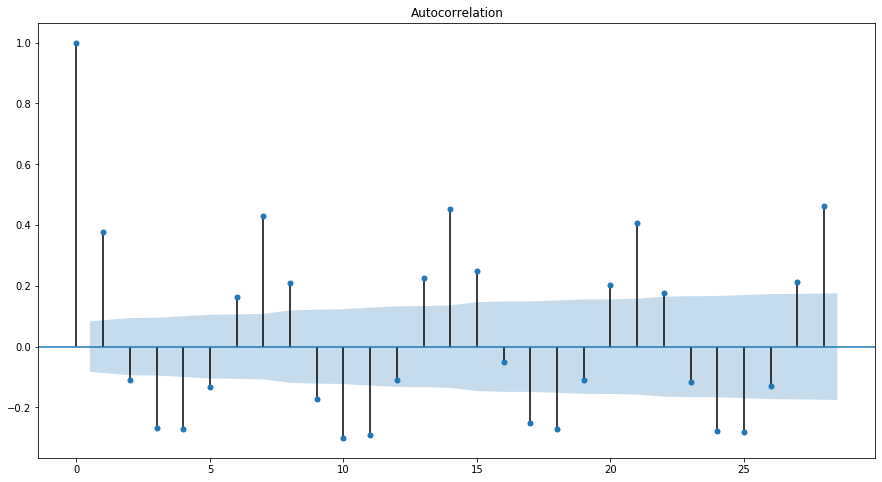

In [57]:
acf = smg.tsaplots.plot_acf(daily_sales_ts_trunc)

def getValueWithLag(date, lag):
    """
    Find the sales value at a date that has the given lag with the given date.
    """
    lagged_datetime = date - timedelta(days=lag)
    if y.index.contains(lagged_datetime):
        return y[date - timedelta(days=1)]
    else:
        return float("nan")

As a result, the feature we will be using are :
- The day of the year as an integer ($\in \left[0, 365\right]$, as we don't have two full years of data, we aren't prone to leap years),  
- The day of the week ($\in \left[1, 7\right]$),  
- The week number ($\in \left[1, 52\right]$),  
- The month as an integer ($\in \left[1, 12\right]$),  
- The sales one day prior ($\in \mathbb{R}^+$),  
- The sales three days prior ($\in \mathbb{R}^+$),  
- The sales four days prior ($\in \mathbb{R}^+$),  
- The sales seven days prior ($\in \mathbb{R}^+$).

In [139]:
y = daily_sales_ts_trunc
X = y.index.to_frame()

X["MONTH"] = X["DATETIME"].apply(lambda date: date.month)
X["WEEK"] = X["DATETIME"].apply(lambda date: int(date.strftime("%V")))
X["WEEKDAY"] = X["DATETIME"].apply(lambda date: date.weekday())
X["DAY"] = range(1, y.count() + 1)
X["DAY"] = X["DAY"].map(lambda day: day % 365)
X["LAG_1_SALES"] = X["DATETIME"].apply(lambda date: getValueWithLag(date, 1))
X["LAG_3_SALES"] = X["DATETIME"].apply(lambda date: getValueWithLag(date, 3))
X["LAG_4_SALES"] = X["DATETIME"].apply(lambda date: getValueWithLag(date, 4))
X["LAG_7_SALES"] = X["DATETIME"].apply(lambda date: getValueWithLag(date, 7))
X["LAG_30_SALES"] = X["DATETIME"].apply(lambda date: getValueWithLag(date, 30))
X["LAG_31_SALES"] = X["DATETIME"].apply(lambda date: getValueWithLag(date, 31))
X = X.iloc[31:] 
y = y.iloc[31:] # Same for the mesured variable to have the corresponding sales vector
X = X.drop(["DATETIME"], axis=1) # Remove datetime as it is not numerical

X_train = X.loc[train.index[31:]] # Removing 31 first days as they have NaN values for lagged sales
X_test = X.loc[test.index]
y_train = y.loc[train.index[31:]]
y_test = y.loc[test.index]

display(X_train.head())
display(X_test.head())

,MONTH,WEEK,WEEKDAY,DAY,LAG_1_SALES,LAG_3_SALES,LAG_4_SALES,LAG_7_SALES,LAG_30_SALES,LAG_31_SALES
DATETIME,,,,,,,,,,
1900-06-01,6,22,4,32,11972.37,11972.37,11972.37,11972.37,11972.37,11972.37
1900-06-02,6,22,5,33,13803.83,13803.83,13803.83,13803.83,13803.83,13803.83
1900-06-03,6,22,6,34,8743.74,8743.74,8743.74,8743.74,8743.74,8743.74
1900-06-04,6,23,0,35,10327.56,10327.56,10327.56,10327.56,10327.56,10327.56
1900-06-05,6,23,1,36,8147.01,8147.01,8147.01,8147.01,8147.01,8147.01


,MONTH,WEEK,WEEKDAY,DAY,LAG_1_SALES,LAG_3_SALES,LAG_4_SALES,LAG_7_SALES,LAG_30_SALES,LAG_31_SALES
DATETIME,,,,,,,,,,
1901-07-20,7,29,5,81,15691.73,15691.73,15691.73,15691.73,15691.73,15691.73
1901-07-21,7,29,6,82,12929.48,12929.48,12929.48,12929.48,12929.48,12929.48
1901-07-22,7,30,0,83,13182.32,13182.32,13182.32,13182.32,13182.32,13182.32
1901-07-23,7,30,1,84,10804.94,10804.94,10804.94,10804.94,10804.94,10804.94
1901-07-24,7,30,2,85,9589.80,9589.80,9589.80,9589.80,9589.80,9589.80


##### 2.4.2.2 Hyper-parameters tuning using randomized search

As each node of ensemble trees will select the best features for us, no further feature engineering is needed. However, we need the random forest to have the best hyper-parameters set.

We can create our Random Forest *sklearn* object and list hyper-parameters :

In [95]:
rf = RandomForestRegressor()
display(rf.get_params())

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Among most important parameters listed in the [object documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html), we find `n_estimators`, `max_features`, `max_depth`, `min_samples_split`, `min_samples_leaf` and `bootstrap`. We defined this search space as :  
- `n_estimators` $ \in \{x | x \in \left[50, 2000\right] \land x\bmod50 = 0\} $. We consider that with less than 50 trees we may risk to miss some features. With more than 2000, the computation cost will probably not be worth the accuracy gain.
- `max_features` $ \in \{'auto', 'sqrt'\}$
- `max_depth` $ \in \{x | (x \in \left[5, 600\right] \land x\bmod5 = 0) \lor (x = 'None') \} $. We want to consider the most extreme case, with an unbalanced binary tree, containing $N$ leaves, where $N$ is our number of observation. In that case, we have a $N - 1$ depth. As a result, we choose that depth since our training set doesn't exceed 600 observations.
- `min_samples_split` $ \in \{2, 3, 4, 5, 6, 7, 8, 9, 10\}$  
- `min_samples_leaf` $ \in \{1, 2, 3, 4, 5\}$
- `bootstrap` $ \in \{'True', 'False'\}$  
  
As our search space contains $871 200$ models to evaluate, we will use a random cross validation search. Our cross-validation will, as we have done for the SARIMA model, use a forward chaining strategy.

In [105]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Generating forward chaining cross-validation set
tscv = TimeSeriesSplit(n_splits=10)
cv = tscv.split(X_train)

# Generat
n_estimators = np.linspace(start = 50, stop = 2000, num = 40).astype(int).tolist()
max_features = ['auto', 'sqrt']
max_depth = np.linspace(5, 700, num = 120).astype(int).tolist()
max_depth.append(None)
min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9, 10]
min_samples_leaf = [1, 2, 3, 4, 5]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 1000, cv=cv, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 32.7min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 38.2min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

{'n_estimators': 250,
 'min_samples_split': 3,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 5,
 'bootstrap': True}

This gives us hyper parameters :  
- `n_estimators` $ = 250$,  
- `min_samples_split` $ = 3$,  
- `min_samples_leaf` $ = 2$,  
- `max_features` $ = 'auto'$,  
- `max_depth` $ = 5$,  
- `bootstrap` $ = 'True'$

##### 2.4.2.3 Forecasting using Random Forest

We will first predict for our test set dates and plot it.

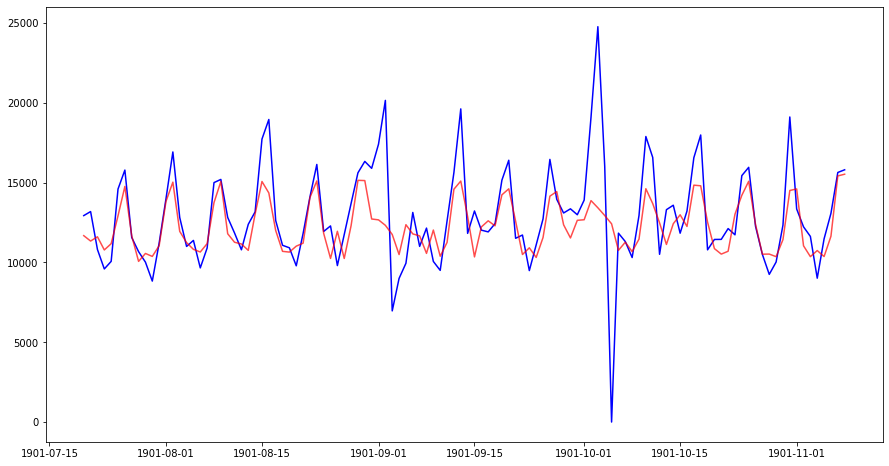

In [233]:
random_forest_model = RandomForestRegressor(n_estimators=250, max_depth=5, min_samples_split=3, min_samples_leaf=2, max_features='auto', bootstrap=True)
random_forest_model.fit(X_train, y_train)
random_forest_predictions = random_forest_model.predict(X_test)
random_forest_predictions = pd.Series(random_forest_predictions, index=X_test.index) # Sklearn doesn't return indices so we put them back in the result

plt.plot(test, 'b')
plt.plot(random_forest_predictions, 'r', alpha = 0.7)
plt.show()

The random forest model shares similar characteristics with the SARIMA model that we trained before :
- It captures the weekly seasonality well,
- It captures the stable mean weekly sales,
- It fails to capture yearly spikes,
- It fails to capture the variability between the different weeks.

One of the advantages of using a rando forest is that important features can be infered from trees boundaries.
MOST IMPORTANT FEATURES

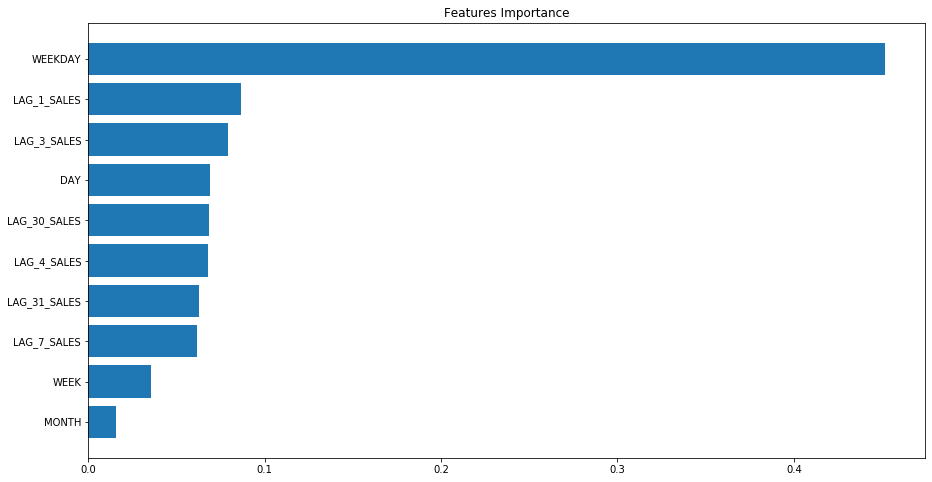

In [121]:
# Feature importance
features = X_test.columns
importances = random_forest_model.feature_importances_
indices = np.argsort(importances)

plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), features[indices])
plt.title('Features Importance')
plt.show()

We see that weekday is really important. It is probably the feature with which trees detect weekly seasonality.  
  
We can now use the model to predict week 98. But as we used lagged values as feature, we need to do a day forward prediction in order to create features as we forecast.

In [205]:
current_date = y_test.index[-1] + timedelta(1)
week_98_start = datetime(1900, 1, 1) + timedelta(97*7 + 1)
week_98_end = datetime(1900, 1, 1) + timedelta(98*7)
week_98_sales = []


# Copying data matrix to avoid modifying them with new forecasts
y_forecast = y.copy()
X_forecast = X.copy()

# Computing features and forecast for upcoming days until last day of week 98
while(current_date < week_98_end):
    # Increment
    current_date = (current_date + timedelta(1))
    
    # Features
    X_forecast.loc[current_date] = {
        'MONTH': current_date.month,
        'WEEK': int(current_date.strftime("%V")),
        'WEEKDAY': current_date.weekday(),
        'DAY': X_forecast.loc[X_forecast.index[-1]]["DAY"] + 1,
        'LAG_1_SALES': y_forecast.loc[y_forecast.index[-1]],
        'LAG_3_SALES': y_forecast.loc[y_forecast.index[-3]],
        'LAG_4_SALES': y_forecast.loc[y_forecast.index[-4]],
        'LAG_7_SALES': y_forecast.loc[y_forecast.index[-7]],
        'LAG_30_SALES': y_forecast.loc[y_forecast.index[-30]],
        'LAG_31_SALES': y_forecast.loc[y_forecast.index[-31]]
    }
    
    # Forecast
    y_forecast.loc[current_date] = random_forest_model.predict(X_forecast.loc[[current_date]])[0]

    if current_date >= week_98_start:
        week_98_sales.append(y_forecast.loc[current_date])

sum(week_98_sales)

91280.44115857109

**The total forecasted sales by the random forest model for week 98 is $\$91280.44$.**

## 3. Results

Now that we have two tuned models, we can compare them on the test set. Let's first plot the two model's predictions on the test set over the real time serie.

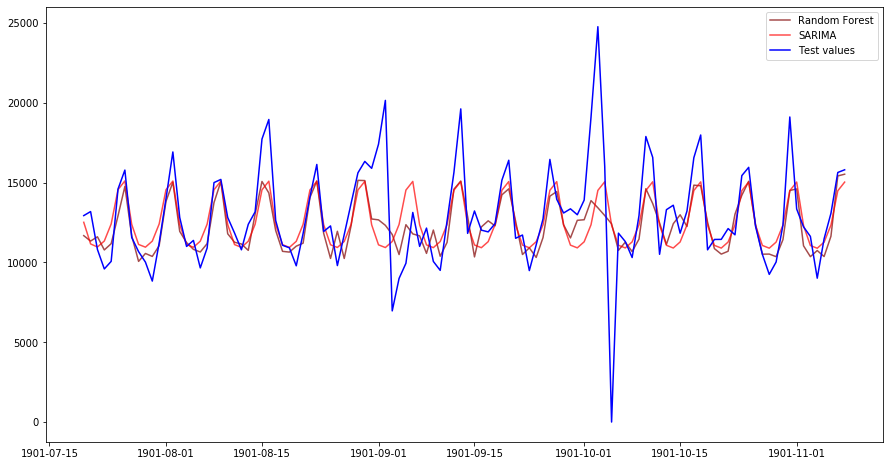

In [234]:
plt.plot(random_forest_predictions, 'maroon', alpha=0.7, label="Random Forest")
plt.plot(sarima_predictions, 'r', alpha=0.7, label="SARIMA")
plt.plot(test, 'b', label="Test values")
plt.legend(loc='best')
plt.show()

We will measure accuarcy and RMSE.

In [248]:
print("Score for SARIMA Model :")
print({
    "RMSE": math.sqrt(mean_squared_error(sarima_predictions, test)),
    "MAE": mean_absolute_error(sarima_predictions, test),
    "MAPE": np.mean(np.abs((test - sarima_predictions) / test)) * 100
})

print("\n\nScore for Random Forest Model :")
print({
    "RMSE": math.sqrt(mean_squared_error(random_forest_predictions, test)),
    "MAE": mean_absolute_error(random_forest_predictions, test),
    "MAPE": np.mean(np.abs((test - random_forest_predictions) / test)) * 100
})

mean_combination_predictions = (sarima_predictions + random_forest_predictions) / 2
print("\n\nScore for Combined Model :")
print({
    "RMSE": math.sqrt(mean_squared_error(mean_combination_predictions, test)),
    "MAE": mean_absolute_error(mean_combination_predictions, test),
    "MAPE": np.mean(np.abs((test - mean_combination_predictions) / test)) * 100
})

Score for SARIMA Model :
{'RMSE': 2526.7644358575762, 'MAE': 1590.911649313069, 'MAPE': 3692.173938901198}


Score for Random Forest Model :
{'RMSE': 2453.907953761379, 'MAE': 1585.7819672545736, 'MAPE': 3717.650090041294}


Score for Combined Model :
{'RMSE': 2451.8274917483573, 'MAE': 1547.4776611675838, 'MAPE': 3704.574111310005}


We see that when comparing key error measures, none of the models comes out, and measures are pretty close. Among these measures, all have their pros and cons and choosing one above the others seem still controversial ([6]). Even a straightforward mean combination of the models doesn't reduce error measures ([7]).

As a results, model choice in our specific case will mostly rely on implementation based criteria. And thus we would go with SARIMA, as it better allows to see what is under the wood thanks as it is parametric and linear, and doesn't include randomness.

## 4. Resources

[1] Box, G. E. P., and G. C. Tiao. “Intervention Analysis with Applications to Economic and Environmental Problems.” Journal of the American Statistical Association, vol. 70, no. 349, 1975, pp. 70–79.  
[2] Din, Marilena. (2015). ARIMA by Box Jenkins Methodology for Estimation and Forecasting Models in Higher Education. 10.13140/RG.2.1.1259.6888.  
[3] Kumar, S.V. & Vanajakshi, L. Eur. Transp. Res. Rev. (2015) 7: 21. https://doi.org/10.1007/s12544-015-0170-8  
[4] https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9  
[5] Ho, T.K. (1995) Random Decision Forest. Proceedings of the 3rd International Conference on Document Analysis and Recognition, Montreal, 14-16 August 1995, 278-282.  
[6] Davydenko, Andrey & Fildes, Robert. (2016). Forecast Error Measures: Critical Review and Practical Recommendations. 10.13140/RG.2.1.4539.5281.
[8] J. Scott Armstrong. "Combining forecasts: The end of the beginning or the beginning of the end?" The Wharton School, University of Pennsylvania, Philadelphia, PA 19104, USA 
[8] Pavlyshenko, B.M. Machine-Learning Models for Sales Time Series Forecasting. Data 2019, 4, 15.